# Import relevant libraries and packages. 

In [1]:
import nidaqmx
from nidaqmx import Task
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import serial
from serial.tools import list_ports
import time
import datetime
import scipy
from scipy.optimize import curve_fit
import warnings
import matplotlib
%matplotlib notebook

# Define Functions 

Define the functions that will be used to acquire data

In [2]:
def get_device_port():
    
    """
    'get_device_port'  obtains the pump device port which is usually the highest device port

    Returns: 
        Device Port
    """
    
    #Iterate through list in reverse to get highest device COM port
    for comport in reversed(list_ports.comports()):
        device_name = comport.device
        with serial.Serial(device_name, timeout=3) as ser: 
            ser.write(b'/1?\r')
            reading=ser.read_until(b'\r')
            if(reading):
                return device_name
    raise IOError("Syringe not found")


In [3]:
def get_potential_measurement(samp_rate, samp_num):
    
    '''
    'get_voltage_measurement' makes a single potential acquisition. Each acquisition samples the potential
    some number of times at some sampling rate.
    
    The function takes two arguments:
        samp_rate = rate at which data is sampled per second 
        samp_num = total number of samples in a single data aquisition
        
    and returns:
       v_m = a list of all potentials sampled in the data acquisition
        
    '''
        
    # get a list of devices
    all_devices = list(nidaqmx.system.System.local().devices)
    
    # throw error if no devices are found or if multiple devices are found
    if (len(all_devices) == 0):
        raise IOError("No DAQ device found")
    if (not (len(all_devices) == 1)):
        warnings.warn("More than one DAQ device found. Using the first device. \
            Manually change dev_name to use other device")
        
    # otherwise use the first device that's found
    dev_name = all_devices[0].name
    
    # collect data, assign to v_m
    with Task() as task:
        
        # add input channel and set E range ( For CHEM174/274 potentiostat E range is always [-10,10] )
        task.ai_channels.add_ai_voltage_chan(dev_name + "/ai0", max_val=10, min_val=-10)
        
        '''
        # set the input voltage range to [-1,1] (not used in A2021)
        task.ai_channels.all.ai_min = -1
        task.ai_channels.all.ai_max = 1
        '''
        
        # set sampling rate and number of samples in acquisition 
        task.timing.cfg_samp_clk_timing(samp_rate, samps_per_chan=samp_num)
        
        # collect data from daq
        v_m = task.read(samp_num, timeout=nidaqmx.constants.WAIT_INFINITELY)
        
    return v_m
    

In [4]:
def fit_func(x, m, b):
    
    '''
    This is some function used to fit the calibration data. E.g. linear fit for the pH vs potential calibration.
    x is the independent variable, m is the gradient, and b is a constant
    '''
    
    return m*x+b

# Potentiometry

Code block 1 initialises the data from each potential acquisition. It will also ask for a filename which will be used to name the recorded data and plots. 

Code block 2 makes a potential acquisition. For each acquisition you will be asked to define what that acquisition is. Running code block 2 multiple times will continously add new data points to the plot and exported datafile. You may change the sampling rate and sampling number between each acquisition. 

Run code block 1 again to start a new experiment or reset the plot.

In [36]:
'''CODE BLOCK 1'''

# stores the mean and standard deviation of each potential acquisition 
mean_meas = []
std_meas = []

# x axis label for each acquisition 
sol_num = [] 

# ask for the name of measurement. This will be used for the filenames for the exported data and plots
filename = input('File name is:')

File name is:o


Name of acquisition:k


<IPython.core.display.Javascript object>


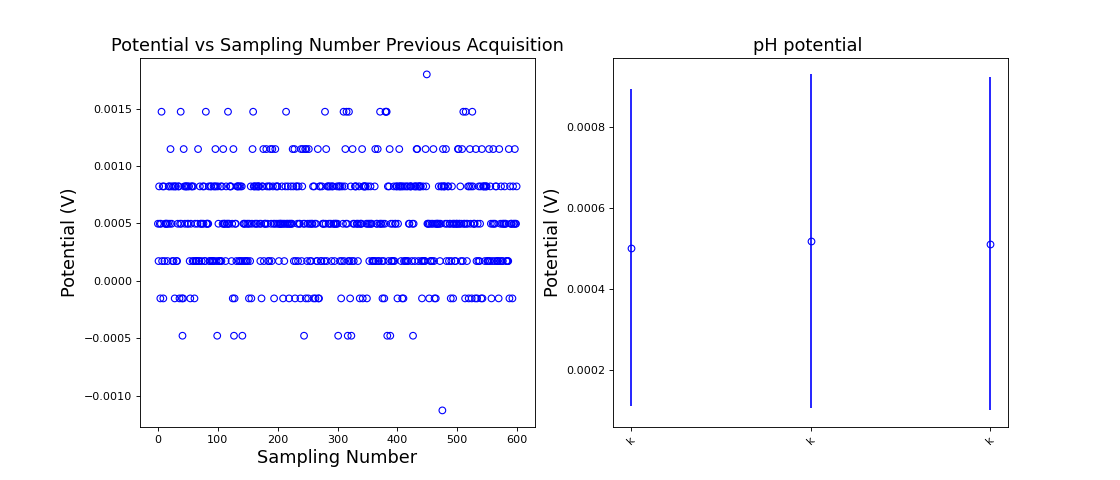

  Solution  mean potential   std dev
0        k        0.000502  0.000392
1        k        0.000517  0.000413
2        k        0.000511  0.000413


In [35]:
'''CODE BLOCK 2'''

# ask user to define x axis tick label for the acquisition (can be solution concentration or anything) and append to 'sol_conc' array
acq_name = input('Name of acquisition:')
sol_num.append(acq_name)

# define sampling rate and sampling number 
samp_rate = 600
samp_num = 600

# collect data
measured_potential = get_potential_measurement(samp_rate, samp_num)

# append mean and standard deviation of potential to 'mean_meas' and 'std_meas' which store data from all acquisitions
mean_meas.append(np.mean(measured_potential))
std_meas.append(np.std(measured_potential))

# set up subplot 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

# subplot 1 
ax1.scatter(np.arange(len(measured_potential)), measured_potential, facecolors='none', edgecolor = 'b')
ax1.set_title('Potential vs Sampling Number Previous Acquisition', fontsize = 16)
ax1.set_xlabel('Sampling Number', fontsize = 16)
ax1.set_ylabel('Potential (V)', fontsize = 16)

# subplot 2 
ax2.errorbar(x = np.arange(len(mean_meas)), y = mean_meas , yerr = std_meas,  fmt='bo', fillstyle = 'none')
ax2.set_title('pH potential ', fontsize = 16)
ax2.set_ylabel('Potential (V)', fontsize = 16)
ax2.set_xticks(np.arange(0, len(sol_num))) 
ax2.set_xticklabels(sol_num) 

# Save figure in the current directory. Note this will overwrite existing images with the same filename 
plt.xticks(rotation=45) # rotate xtics
plt.savefig(filename + '.png', dpi = 300, bbox_inches='tight')

# save data
exported_data = pd.DataFrame({'Solution': sol_num , 'mean potential': mean_meas, 'std dev': std_meas})
print(exported_data)
exported_data.to_csv(filename + '.txt', index = False)

# Linear fit

Code block 3 imports data and does a linear fit. This may be used to generate a calibration curve for pH vs potential. 

<IPython.core.display.Javascript object>


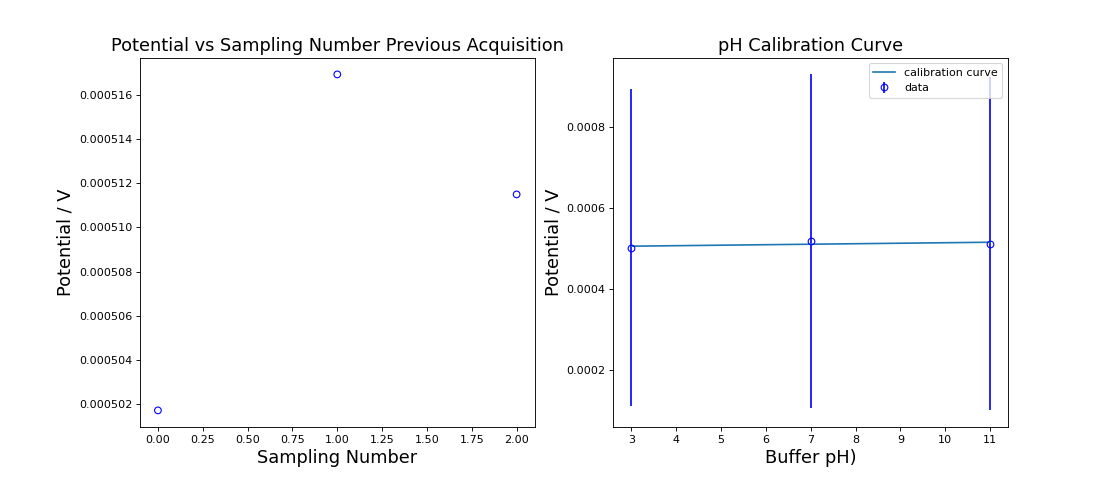

The calibration curve is y = 1.2204024824380163e-06x + 1.2204024824380163e-06
The fit covariance is [[ 2.21262238e-12 -1.54883595e-11]
 [-1.54883595e-11  1.32019830e-10]]


In [37]:
'''
CODE BLOCK 3
'''

# import data
data = pd.read_csv('k.txt')

# pH of buffer solutions. Make sure to define the pH in the array in the same sequence you have run them
buffer_pH = np.array([3, 7, 11])

# fit buffer solution data to fit_func. fit_param is a tuple which contains the fitted variables and fit covariance
fit_param = curve_fit(fit_func, buffer_pH, data['mean potential'])

# set up subplot 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

# subplot 1 
ax1.scatter(np.arange(len(data['mean potential'])), data['mean potential'], facecolors='none', edgecolor = 'b')
ax1.set_title('Potential vs Sampling Number Previous Acquisition', fontsize = 16)
ax1.set_xlabel('Sampling Number', fontsize = 16)
ax1.set_ylabel('Potential / V', fontsize = 16)

# subplot 2 
# buffer solution data
ax2.errorbar(x = buffer_pH, y = data['mean potential'] , yerr = data['std dev'],  fmt='bo', 
             label ='data', fillstyle='none') 

# fitted calibration curve 
ax2.plot(buffer_pH, fit_func(buffer_pH, fit_param[0][0], fit_param[0][1]), label = 'calibration curve') 

ax2.set_title('pH Calibration Curve', fontsize = 16)
ax2.set_ylabel('Potential / V', fontsize = 16)
ax2.set_xlabel('Buffer pH)', fontsize = 16)
print(f'The calibration curve is y = {fit_param[0][0]}x + {fit_param[0][0]}')
print(f'The fit covariance is {fit_param[1]}')
ax2.legend()

plt.show()

In [25]:
data['mean potential']

0    0.000606
1    0.000606
2    0.000644
Name: mean potential, dtype: float64

# Importing data and replotting

Cell block 3 shows an example of importing 2 data sets and doing some correction on the data. The corrected data are then plotted together. You may choose to import multiple datasets, do some processing like normalisation and then plot everything together to compare them.  

In [ ]:
'''Cell block 3'''

# Importing data into dataframes. Import as many files as necessary.
data1 = pd.read_csv('CV1.txt')
data2 = pd.read_csv('CV2.txt')


'''#Examples of altering imported data'''
# replace the 'WE potential' column with the doubled value in data1 dataframe
data1['WE potential'] = data1['WE potential']*2 

# uncompesnated resistance in ohms
Ru = 100
# subtract the overpotential attributed to the uncompesnated resistance in data2
data2['WE potential'] = data2['WE potential'] - data2['Rm current']*Ru 


'''plot data'''
fig, ax = plt.subplots(figsize = (12, 10))
plt.title('CV data')
plt.subplots_adjust(right=0.7)
plt.subplots_adjust(bottom=0.3)

# plot data from dataframes of interest
data1.plot(kind = 'line', x = 'WE potential', y = 'Rm current', label = 'data1 modified', ax =ax)
data2.plot(kind = 'line', x = 'WE potential', y = 'Rm current', label = 'data2 modified', ax =ax)
#data3.plot(kind = 'line', x = 'WE potential', y = 'Rm current', label = file, ax =ax)

ax.set_title('Cyclic Voltammogram', fontsize = 16)
ax.set_ylabel('Current/A')
ax.tick_params(axis='both',which='both',direction='in',right=True, top=True)
ax.set_xlabel('$E_{\mathrm{cell}}$ / V', fontsize = 16)
ax.set_ylabel('$i_{\mathrm{w}}$ / A', fontsize = 16)
ax.ticklabel_format(axis = 'y', style='sci', scilimits = (-2, 3)) 
#ax.set_aspect('equal', 'box')
#ax.set_xlim((0, 500))
#ax.set_ylim((-0.03, 0.03))
plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.7, bottom=0.3, top=0.9)
plt.legend()